In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import os
import pickle
import sys
from scipy import sparse
from pandas.api.types import CategoricalDtype

# show all columns and all column content
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

pool_names = ['BTC/USDC', 'ETH/USDC', 'YFI/USDC', 'DOT/USDC', 'SNX/USDC',
            'LINK/USDC', 'AAVE/USDC', 'SUSHI/USDC', 'COMP/USDC', 'REN/USDC',
            'PERP/USDC', 'UNI/USDC', 'CRV/USDC', 'MKR/USDC', 'CREAM/USDC',
            'GRT/USDC', 'ALPHA/USDC', 'FTT/USDC']

In [2]:
def hued_lineplot(df: pd.DataFrame, column_1: str, column_2: str, hued_column: str,
                  labels: list, xlabel: str, ylabel: str, title: str, 
                  color_set: str='Set1', xsize: int=30, ysize: int=15,
                  is_grid_required: bool=False):
    """Hued lineplot

    Args:
        df (pd.DataFrame): data to plot
        column_1 (str): x axis column
        column_2 (str): y axis column
        hued_column (str): column based on which hue will be performed
        labels (list): categories based on which hue will be done
        xlabel (str): x axis name
        ylabel (str): y axis name
        title (str): name of the chart
        color_set (str, optional): color set chosen for plotting lines. Defaults to 'Set1'.
        xsize (int, optional): x size of chart. Defaults to 30.
        ysize (int, optional): y size of chart. Defaults to 15.
        is_grid_required (bool, optional): is grid of the chart required. Defaults to False
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    rgb_values = sns.color_palette(color_set, len(labels))
    color_map = dict(zip(labels, rgb_values))
    
    for label in labels:
        ax.plot(df[df[hued_column] == label][column_1], df[df[hued_column] == label][column_2],
                color=color_map[label], label=label)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.grid(is_grid_required)
    plt.show()

In [3]:
overall_history_list = []
for amm_name in pool_names:
    amm_history = pd.read_csv('' + amm_name.split('/')[0].lower() + '_usdc_indexed_position.csv')
    print('amm ' + amm_name + ' has ' + str(len(amm_history[(amm_history['position_size_after'] == 0) &
                                                           (amm_history['exchanged_position_size'] != 0)])) + 
                                                ' closes')
    overall_history_list.append(amm_history)
    
opens_closes_positions_df = pd.concat(overall_history_list)
opens_closes_positions_df['timestamp'] = pd.to_datetime(opens_closes_positions_df['timestamp'])

amm BTC/USDC has 34253 closes
amm ETH/USDC has 44866 closes
amm YFI/USDC has 64003 closes
amm DOT/USDC has 82901 closes
amm SNX/USDC has 94867 closes
amm LINK/USDC has 65534 closes
amm AAVE/USDC has 78000 closes
amm SUSHI/USDC has 94437 closes
amm COMP/USDC has 72679 closes
amm REN/USDC has 89550 closes
amm PERP/USDC has 83685 closes
amm UNI/USDC has 55174 closes
amm CRV/USDC has 93346 closes
amm MKR/USDC has 47335 closes
amm CREAM/USDC has 61454 closes
amm GRT/USDC has 72325 closes
amm ALPHA/USDC has 56656 closes
amm FTT/USDC has 39502 closes


# Sparse matrix of trading activity by trader on each amm

In [4]:
amm_trader_list = []

for amm in opens_closes_positions_df['amm_name'].unique():
    amm_story = opens_closes_positions_df[opens_closes_positions_df['amm_name'] == amm]
    amm_trader_df = pd.DataFrame(columns=['amm', 'trader'])
    amm_trader_df['trader'] = amm_story['trader'].unique()
    amm_trader_df['amm'] = [amm] * len(amm_story['trader'].unique())
    amm_trader_list.append(amm_trader_df)
    
traders_amm_df = pd.concat(amm_trader_list)
traders_amm_df["count"] = [1] * len(traders_amm_df)
traders_amm_df

,amm,trader,count
0,BTC/USDC,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,1
1,BTC/USDC,0x9602686bf53a17baed60c48ba34ed4219a532381,1
2,BTC/USDC,0x43bd90e4cc93d6e40580507102cc7b1bc8a25284,1
3,BTC/USDC,0x5bea7caa02142ba59885466757e1112819731f09,1
4,BTC/USDC,0x069a67b8f965d02d095be12ae55e31e769692df4,1
...,...,...,...
561,FTT/USDC,0xc0f872a7127bdc6d98af04899d1a1d22376c7b6b,1
562,FTT/USDC,0x419df1d41f84de3d3854a4e6d0b4d772ebd1b13b,1
563,FTT/USDC,0xb39885f302643a5f96f743c3621d628dc3f72ce6,1
564,FTT/USDC,0xa84daa76815f6d2cf99e406bd693e8588bc36dbe,1


In [5]:
users = traders_amm_df["trader"].unique()
amms = traders_amm_df["amm"].unique()
shape = (len(users), len(amms))

user_cat = CategoricalDtype(categories=sorted(users), ordered=True)
amms_cat = CategoricalDtype(categories=sorted(amms), ordered=True)

user_index = traders_amm_df["trader"].astype(user_cat).cat.codes
amm_index = traders_amm_df["amm"].astype(amms_cat).cat.codes

# Conversion via COO matrix
coo = sparse.coo_matrix((traders_amm_df["count"], (user_index, amm_index)), shape=shape)
csr = coo.tocsr()

In [6]:
stats_df = pd.DataFrame.sparse.from_spmatrix(csr, columns=amms_cat.categories)
stats_df.index = user_cat.categories
stats_df['occurencies_sum'] = stats_df.sum(axis=1)
stats_df

,AAVE/USDC,ALPHA/USDC,BTC/USDC,COMP/USDC,CREAM/USDC,CRV/USDC,DOT/USDC,ETH/USDC,FTT/USDC,GRT/USDC,LINK/USDC,MKR/USDC,PERP/USDC,REN/USDC,SNX/USDC,SUSHI/USDC,UNI/USDC,YFI/USDC,occurencies_sum
0x000000003b0371b33aba8b6b58154a98d54695ad,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
0x000000064730640b7d670408d74280924883064f,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
0x0000000813b34008a225de08a6a61835508c71f9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0x000000ea89990a17ec07a35ac2bbb02214c50152,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17
0x0000ce08fa224696a819877070bf378e8b131acf,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xffe694afb3b54ee0add6ded4cc0f9917777f13da,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
0xfffb40347816873ca038756cc87bc610144166b2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
0xfffdd2572f57b6457c8c4b0320e8f1f1ec4812bd,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
0xfffe45d946f1f715dc0252df3db22a9edfaf5738,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


# Solving capitalization question with ```position_notional```

In [7]:
opens_closes_positions_df.drop(columns=['Unnamed: 0'], inplace=True)
opens_closes_positions_df

,id,trader,amm,margin,position_notional,exchanged_position_size,fee,position_size_after,realized_pnl,unrealized_pnl_after,bad_debt,liquidation_penalty,spot_price,funding_payment,block_number,timestamp,amm_name,open_close_id,open_id
0,0x06d54c4ad4bfff493051ef548557f4fa0c76fb2dd6787fd665f3b9bf001ad88e-20,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,5.552446e+03,1.665734e+04,8.727098e-01,16.657338,8.727098e-01,0.000000e+00,0.000000,0.0,0.0,19120.287600,0.000000,13508290,2020-12-14 03:16:05,BTC/USDC,0.0,1.0
1,0xe9d804889de5a27a356777a588d6c018e55fa1cae61c6265f11595c4c293a697-6,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,1.111460e+04,1.668646e+04,8.711866e-01,16.686462,1.743896e+00,0.000000e+00,58.249669,0.0,0.0,19187.208607,0.000000,13508954,2020-12-14 04:11:45,BTC/USDC,0.0,1.0
2,0xea81e16520eae51395b4627365487daa2013df876ef3e38254579d1d149b17fd-6,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,0.000000e+00,3.334380e+04,-1.743896e+00,33.343800,0.000000e+00,-1.782200e-14,0.000000,0.0,0.0,19053.600000,0.000000,13509011,2020-12-14 04:16:30,BTC/USDC,0.0,1.0
3,0xcbc30cda2cff5814702d67c67530f6598a670ad990f3875e8e314c564279df13-6,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,5.555467e+03,1.666640e+04,8.722351e-01,16.666402,8.722351e-01,0.000000e+00,0.000000,0.0,0.0,19141.103310,0.000000,13511238,2020-12-14 07:23:25,BTC/USDC,16.0,2.0
4,0xb7f635c0407feb60d7386e18b0d102503e5c9f034be9791bd961f75d22aceb69-6,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,1.112383e+04,1.670391e+04,8.702764e-01,16.703914,1.742512e+00,0.000000e+00,75.042344,0.0,0.0,19227.363807,-0.395807,13512310,2020-12-14 08:53:25,BTC/USDC,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301908,0x46558498bb5962a524f0b63d724d92777bb17b504e44441415f66ecdd6b4fa3f-12,0xb39885f302643a5f96f743c3621d628dc3f72ce6,0x838b322610bd99a449091d3bf3fba60d794909a9,3.690119e+03,2.154072e+03,5.000000e+01,2.154072,3.000000e+02,0.000000e+00,-0.785120,0.0,0.0,43.091241,0.000000,21019327,2022-03-09 11:41:00,FTT/USDC,0.0,1.0
301909,0x3ddf503cacc2125a68cc17a9b84e2971d6242423eea0175b6a7a93bd2bd82b80-13,0xb39885f302643a5f96f743c3621d628dc3f72ce6,0x838b322610bd99a449091d3bf3fba60d794909a9,1.100000e-17,1.286891e+04,-3.000000e+02,12.868911,-1.000000e-18,-4.650566e+01,0.000000,0.0,0.0,42.837940,-1.905190,21021513,2022-03-09 14:54:15,FTT/USDC,0.0,1.0
301910,0x4215d5f56936f1604171ada50922c0e5af609369ea109981b0f9cd8d925662bc-25,0xb39885f302643a5f96f743c3621d628dc3f72ce6,0x838b322610bd99a449091d3bf3fba60d794909a9,0.000000e+00,4.300000e-17,1.000000e-18,0.000000,0.000000e+00,-2.000000e-18,0.000000,0.0,0.0,42.869642,0.000000,21021523,2022-03-09 14:55:10,FTT/USDC,0.0,1.0
301911,0x507dae82675d33cc29766b5792ef6c527149ac4ddae469e5a9ead2e606ec9c80-8,0xa84daa76815f6d2cf99e406bd693e8588bc36dbe,0x838b322610bd99a449091d3bf3fba60d794909a9,1.000000e+00,1.500000e+00,3.664475e-02,0.001500,3.664475e-02,0.000000e+00,0.000000,0.0,0.0,40.933570,0.000000,21061399,2022-03-12 00:22:55,FTT/USDC,1231736.0,1.0


In [8]:
opens_closes_positions_df['custom_position_capitalization'] = (opens_closes_positions_df['position_size_after'] *
                                                               opens_closes_positions_df['spot_price'])
opens_closes_positions_df

,id,trader,amm,margin,position_notional,exchanged_position_size,fee,position_size_after,realized_pnl,unrealized_pnl_after,bad_debt,liquidation_penalty,spot_price,funding_payment,block_number,timestamp,amm_name,open_close_id,open_id,custom_position_capitalization
0,0x06d54c4ad4bfff493051ef548557f4fa0c76fb2dd6787fd665f3b9bf001ad88e-20,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,5.552446e+03,1.665734e+04,8.727098e-01,16.657338,8.727098e-01,0.000000e+00,0.000000,0.0,0.0,19120.287600,0.000000,13508290,2020-12-14 03:16:05,BTC/USDC,0.0,1.0,1.668646e+04
1,0xe9d804889de5a27a356777a588d6c018e55fa1cae61c6265f11595c4c293a697-6,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,1.111460e+04,1.668646e+04,8.711866e-01,16.686462,1.743896e+00,0.000000e+00,58.249669,0.0,0.0,19187.208607,0.000000,13508954,2020-12-14 04:11:45,BTC/USDC,0.0,1.0,3.346050e+04
2,0xea81e16520eae51395b4627365487daa2013df876ef3e38254579d1d149b17fd-6,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,0.000000e+00,3.334380e+04,-1.743896e+00,33.343800,0.000000e+00,-1.782200e-14,0.000000,0.0,0.0,19053.600000,0.000000,13509011,2020-12-14 04:16:30,BTC/USDC,0.0,1.0,0.000000e+00
3,0xcbc30cda2cff5814702d67c67530f6598a670ad990f3875e8e314c564279df13-6,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,5.555467e+03,1.666640e+04,8.722351e-01,16.666402,8.722351e-01,0.000000e+00,0.000000,0.0,0.0,19141.103310,0.000000,13511238,2020-12-14 07:23:25,BTC/USDC,16.0,2.0,1.669554e+04
4,0xb7f635c0407feb60d7386e18b0d102503e5c9f034be9791bd961f75d22aceb69-6,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,1.112383e+04,1.670391e+04,8.702764e-01,16.703914,1.742512e+00,0.000000e+00,75.042344,0.0,0.0,19227.363807,-0.395807,13512310,2020-12-14 08:53:25,BTC/USDC,0.0,2.0,3.350390e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301908,0x46558498bb5962a524f0b63d724d92777bb17b504e44441415f66ecdd6b4fa3f-12,0xb39885f302643a5f96f743c3621d628dc3f72ce6,0x838b322610bd99a449091d3bf3fba60d794909a9,3.690119e+03,2.154072e+03,5.000000e+01,2.154072,3.000000e+02,0.000000e+00,-0.785120,0.0,0.0,43.091241,0.000000,21019327,2022-03-09 11:41:00,FTT/USDC,0.0,1.0,1.292737e+04
301909,0x3ddf503cacc2125a68cc17a9b84e2971d6242423eea0175b6a7a93bd2bd82b80-13,0xb39885f302643a5f96f743c3621d628dc3f72ce6,0x838b322610bd99a449091d3bf3fba60d794909a9,1.100000e-17,1.286891e+04,-3.000000e+02,12.868911,-1.000000e-18,-4.650566e+01,0.000000,0.0,0.0,42.837940,-1.905190,21021513,2022-03-09 14:54:15,FTT/USDC,0.0,1.0,-4.283794e-17
301910,0x4215d5f56936f1604171ada50922c0e5af609369ea109981b0f9cd8d925662bc-25,0xb39885f302643a5f96f743c3621d628dc3f72ce6,0x838b322610bd99a449091d3bf3fba60d794909a9,0.000000e+00,4.300000e-17,1.000000e-18,0.000000,0.000000e+00,-2.000000e-18,0.000000,0.0,0.0,42.869642,0.000000,21021523,2022-03-09 14:55:10,FTT/USDC,0.0,1.0,0.000000e+00
301911,0x507dae82675d33cc29766b5792ef6c527149ac4ddae469e5a9ead2e606ec9c80-8,0xa84daa76815f6d2cf99e406bd693e8588bc36dbe,0x838b322610bd99a449091d3bf3fba60d794909a9,1.000000e+00,1.500000e+00,3.664475e-02,0.001500,3.664475e-02,0.000000e+00,0.000000,0.0,0.0,40.933570,0.000000,21061399,2022-03-12 00:22:55,FTT/USDC,1231736.0,1.0,1.500000e+00


In [9]:
entire_perpetual_traders_df = stats_df[stats_df['occurencies_sum'] == 18]
bots_positions_df = opens_closes_positions_df[opens_closes_positions_df['trader'].isin(entire_perpetual_traders_df.index)]

```custom_position_capitalization``` can be found using a simple formula:

```custom_position_capitalization = position_size_after * spot_price```

```position_size_after``` represents size of the position in tokens present in the pool. It means that in case of *BTC/USDC* pool ```position_size_after``` equal to 3 means that position size is 3 BTC. Therefore capitalization of the position will be amount of tokens multiplied by price of respective token.

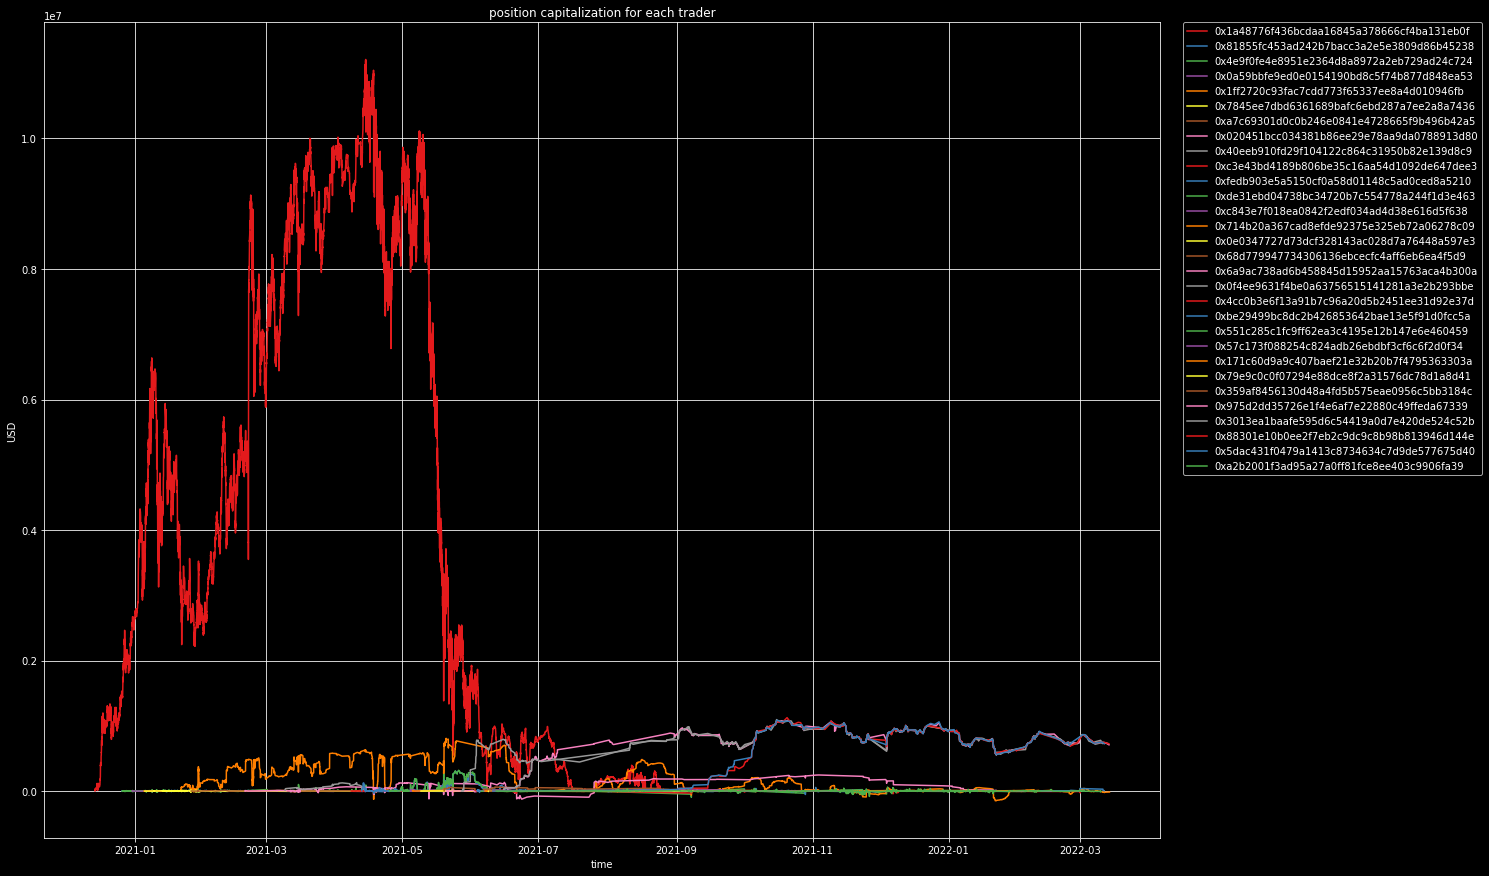

In [10]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'custom_position_capitalization', 'trader', bots_positions_df['trader'].unique()[:30],
              xlabel='time', ylabel='USD', title='position capitalization for each trader', xsize=20, ysize=15, 
              is_grid_required=True)

# making out of ```traders_amm_df``` more complex thing

In [11]:
size = len(traders_amm_df)

traders_amm_df.drop(columns=['count'], inplace=True)
traders_amm_df['total_pnl'] = np.zeros(size)
traders_amm_df['max_found_margin'] = np.zeros(size)
traders_amm_df['median_margin'] = np.zeros(size)
traders_amm_df['max_found_position_notional'] = np.zeros(size)
traders_amm_df['median_position_notional'] = np.zeros(size)
traders_amm_df['min_found_position_notional'] = np.zeros(size)
traders_amm_df['max_found_exchanged_position_size'] = np.zeros(size)
traders_amm_df['median_exchanged_position_size'] = np.zeros(size)
traders_amm_df['min_found_exchanged_position_size'] = np.zeros(size)
traders_amm_df['operations_count'] = np.zeros(size)
traders_amm_df['time_window_seconds'] = np.zeros(size)

In [12]:
traders_amm_df.reset_index(inplace=True)
traders_amm_df.drop(columns=['index'], inplace=True)
traders_amm_df

,amm,trader,total_pnl,max_found_margin,median_margin,max_found_position_notional,median_position_notional,min_found_position_notional,max_found_exchanged_position_size,median_exchanged_position_size,min_found_exchanged_position_size,operations_count,time_window_seconds
0,BTC/USDC,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BTC/USDC,0x9602686bf53a17baed60c48ba34ed4219a532381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BTC/USDC,0x43bd90e4cc93d6e40580507102cc7b1bc8a25284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BTC/USDC,0x5bea7caa02142ba59885466757e1112819731f09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BTC/USDC,0x069a67b8f965d02d095be12ae55e31e769692df4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18240,FTT/USDC,0xc0f872a7127bdc6d98af04899d1a1d22376c7b6b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18241,FTT/USDC,0x419df1d41f84de3d3854a4e6d0b4d772ebd1b13b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18242,FTT/USDC,0xb39885f302643a5f96f743c3621d628dc3f72ce6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18243,FTT/USDC,0xa84daa76815f6d2cf99e406bd693e8588bc36dbe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
for amm in traders_amm_df['amm'].unique():
    print('\n' + amm + ' taken')
    amm_specific_traders_df = traders_amm_df[traders_amm_df['amm'] == amm]
    
    amm_iterations_count = len(amm_specific_traders_df)
    cur_iteration = 0
    
    for trader in amm_specific_traders_df['trader'].unique():
        taken_record = amm_specific_traders_df[(amm_specific_traders_df['trader'] == trader)]
        reviewed_section = opens_closes_positions_df[(opens_closes_positions_df['trader'] == trader) &
                                                    (opens_closes_positions_df['amm_name'] == amm)]
        
        traders_amm_df.loc[taken_record.index, 'total_pnl'] = reviewed_section['realized_pnl'].sum()
        traders_amm_df.loc[taken_record.index, 'max_found_margin'] = reviewed_section['margin'].max()
        traders_amm_df.loc[taken_record.index, 'median_margin'] = reviewed_section['margin'].median()
        traders_amm_df.loc[taken_record.index, 'max_found_position_notional'] = reviewed_section['position_notional'].max()
        traders_amm_df.loc[taken_record.index, 'median_position_notional'] = reviewed_section['position_notional'].median()
        traders_amm_df.loc[taken_record.index, 'min_found_position_notional'] = reviewed_section['position_notional'].min()
        traders_amm_df.loc[taken_record.index, 'max_found_exchanged_position_size'] = reviewed_section['exchanged_position_size'].max()
        traders_amm_df.loc[taken_record.index, 'median_exchanged_position_size'] = reviewed_section['exchanged_position_size'].median()
        traders_amm_df.loc[taken_record.index, 'min_found_exchanged_position_size'] = reviewed_section['exchanged_position_size'].min()
        traders_amm_df.loc[taken_record.index, 'operations_count'] = len(reviewed_section)
        traders_amm_df.loc[taken_record.index, 'operations_count'] = (reviewed_section['timestamp'].max() - 
                                                                      reviewed_section['timestamp'].min()).seconds
        
        cur_iteration += 1
        print("finished " + str(cur_iteration) + " iteration out of " + str(amm_iterations_count))


BTC/USDC taken
finished 1 iteration out of 5023
finished 2 iteration out of 5023
finished 3 iteration out of 5023
finished 4 iteration out of 5023
finished 5 iteration out of 5023
finished 6 iteration out of 5023
finished 7 iteration out of 5023
finished 8 iteration out of 5023
finished 9 iteration out of 5023
finished 10 iteration out of 5023
finished 11 iteration out of 5023
finished 12 iteration out of 5023
finished 13 iteration out of 5023
finished 14 iteration out of 5023
finished 15 iteration out of 5023
finished 16 iteration out of 5023
finished 17 iteration out of 5023
finished 18 iteration out of 5023
finished 19 iteration out of 5023
finished 20 iteration out of 5023
finished 21 iteration out of 5023
finished 22 iteration out of 5023
finished 23 iteration out of 5023
finished 24 iteration out of 5023
finished 25 iteration out of 5023
finished 26 iteration out of 5023
finished 27 iteration out of 5023
finished 28 iteration out of 5023
finished 29 iteration out of 5023
finishe

finished 238 iteration out of 5023
finished 239 iteration out of 5023
finished 240 iteration out of 5023
finished 241 iteration out of 5023
finished 242 iteration out of 5023
finished 243 iteration out of 5023
finished 244 iteration out of 5023
finished 245 iteration out of 5023
finished 246 iteration out of 5023
finished 247 iteration out of 5023
finished 248 iteration out of 5023
finished 249 iteration out of 5023
finished 250 iteration out of 5023
finished 251 iteration out of 5023
finished 252 iteration out of 5023
finished 253 iteration out of 5023
finished 254 iteration out of 5023
finished 255 iteration out of 5023
finished 256 iteration out of 5023
finished 257 iteration out of 5023
finished 258 iteration out of 5023
finished 259 iteration out of 5023
finished 260 iteration out of 5023
finished 261 iteration out of 5023
finished 262 iteration out of 5023
finished 263 iteration out of 5023
finished 264 iteration out of 5023
finished 265 iteration out of 5023
finished 266 iterati

finished 473 iteration out of 5023
finished 474 iteration out of 5023
finished 475 iteration out of 5023
finished 476 iteration out of 5023
finished 477 iteration out of 5023
finished 478 iteration out of 5023
finished 479 iteration out of 5023
finished 480 iteration out of 5023
finished 481 iteration out of 5023
finished 482 iteration out of 5023
finished 483 iteration out of 5023
finished 484 iteration out of 5023
finished 485 iteration out of 5023
finished 486 iteration out of 5023
finished 487 iteration out of 5023
finished 488 iteration out of 5023
finished 489 iteration out of 5023
finished 490 iteration out of 5023
finished 491 iteration out of 5023
finished 492 iteration out of 5023
finished 493 iteration out of 5023
finished 494 iteration out of 5023
finished 495 iteration out of 5023
finished 496 iteration out of 5023
finished 497 iteration out of 5023
finished 498 iteration out of 5023
finished 499 iteration out of 5023
finished 500 iteration out of 5023
finished 501 iterati

finished 708 iteration out of 5023
finished 709 iteration out of 5023
finished 710 iteration out of 5023
finished 711 iteration out of 5023
finished 712 iteration out of 5023
finished 713 iteration out of 5023
finished 714 iteration out of 5023
finished 715 iteration out of 5023
finished 716 iteration out of 5023
finished 717 iteration out of 5023
finished 718 iteration out of 5023
finished 719 iteration out of 5023
finished 720 iteration out of 5023
finished 721 iteration out of 5023
finished 722 iteration out of 5023
finished 723 iteration out of 5023
finished 724 iteration out of 5023
finished 725 iteration out of 5023
finished 726 iteration out of 5023
finished 727 iteration out of 5023
finished 728 iteration out of 5023
finished 729 iteration out of 5023
finished 730 iteration out of 5023
finished 731 iteration out of 5023
finished 732 iteration out of 5023
finished 733 iteration out of 5023
finished 734 iteration out of 5023
finished 735 iteration out of 5023
finished 736 iterati

finished 943 iteration out of 5023
finished 944 iteration out of 5023
finished 945 iteration out of 5023
finished 946 iteration out of 5023
finished 947 iteration out of 5023
finished 948 iteration out of 5023
finished 949 iteration out of 5023
finished 950 iteration out of 5023
finished 951 iteration out of 5023
finished 952 iteration out of 5023
finished 953 iteration out of 5023
finished 954 iteration out of 5023
finished 955 iteration out of 5023
finished 956 iteration out of 5023
finished 957 iteration out of 5023
finished 958 iteration out of 5023
finished 959 iteration out of 5023
finished 960 iteration out of 5023
finished 961 iteration out of 5023
finished 962 iteration out of 5023
finished 963 iteration out of 5023
finished 964 iteration out of 5023
finished 965 iteration out of 5023
finished 966 iteration out of 5023
finished 967 iteration out of 5023
finished 968 iteration out of 5023
finished 969 iteration out of 5023
finished 970 iteration out of 5023
finished 971 iterati

finished 1173 iteration out of 5023
finished 1174 iteration out of 5023
finished 1175 iteration out of 5023
finished 1176 iteration out of 5023
finished 1177 iteration out of 5023
finished 1178 iteration out of 5023
finished 1179 iteration out of 5023
finished 1180 iteration out of 5023
finished 1181 iteration out of 5023
finished 1182 iteration out of 5023
finished 1183 iteration out of 5023
finished 1184 iteration out of 5023
finished 1185 iteration out of 5023
finished 1186 iteration out of 5023
finished 1187 iteration out of 5023
finished 1188 iteration out of 5023
finished 1189 iteration out of 5023
finished 1190 iteration out of 5023
finished 1191 iteration out of 5023
finished 1192 iteration out of 5023
finished 1193 iteration out of 5023
finished 1194 iteration out of 5023
finished 1195 iteration out of 5023
finished 1196 iteration out of 5023
finished 1197 iteration out of 5023
finished 1198 iteration out of 5023
finished 1199 iteration out of 5023
finished 1200 iteration out 

finished 1401 iteration out of 5023
finished 1402 iteration out of 5023
finished 1403 iteration out of 5023
finished 1404 iteration out of 5023
finished 1405 iteration out of 5023
finished 1406 iteration out of 5023
finished 1407 iteration out of 5023
finished 1408 iteration out of 5023
finished 1409 iteration out of 5023
finished 1410 iteration out of 5023
finished 1411 iteration out of 5023
finished 1412 iteration out of 5023
finished 1413 iteration out of 5023
finished 1414 iteration out of 5023
finished 1415 iteration out of 5023
finished 1416 iteration out of 5023
finished 1417 iteration out of 5023
finished 1418 iteration out of 5023
finished 1419 iteration out of 5023
finished 1420 iteration out of 5023
finished 1421 iteration out of 5023
finished 1422 iteration out of 5023
finished 1423 iteration out of 5023
finished 1424 iteration out of 5023
finished 1425 iteration out of 5023
finished 1426 iteration out of 5023
finished 1427 iteration out of 5023
finished 1428 iteration out 

finished 1629 iteration out of 5023
finished 1630 iteration out of 5023
finished 1631 iteration out of 5023
finished 1632 iteration out of 5023
finished 1633 iteration out of 5023
finished 1634 iteration out of 5023
finished 1635 iteration out of 5023
finished 1636 iteration out of 5023
finished 1637 iteration out of 5023
finished 1638 iteration out of 5023
finished 1639 iteration out of 5023
finished 1640 iteration out of 5023
finished 1641 iteration out of 5023
finished 1642 iteration out of 5023
finished 1643 iteration out of 5023
finished 1644 iteration out of 5023
finished 1645 iteration out of 5023
finished 1646 iteration out of 5023
finished 1647 iteration out of 5023
finished 1648 iteration out of 5023
finished 1649 iteration out of 5023
finished 1650 iteration out of 5023
finished 1651 iteration out of 5023
finished 1652 iteration out of 5023
finished 1653 iteration out of 5023
finished 1654 iteration out of 5023
finished 1655 iteration out of 5023
finished 1656 iteration out 

finished 1857 iteration out of 5023
finished 1858 iteration out of 5023
finished 1859 iteration out of 5023
finished 1860 iteration out of 5023
finished 1861 iteration out of 5023
finished 1862 iteration out of 5023
finished 1863 iteration out of 5023
finished 1864 iteration out of 5023
finished 1865 iteration out of 5023
finished 1866 iteration out of 5023
finished 1867 iteration out of 5023
finished 1868 iteration out of 5023
finished 1869 iteration out of 5023
finished 1870 iteration out of 5023
finished 1871 iteration out of 5023
finished 1872 iteration out of 5023
finished 1873 iteration out of 5023
finished 1874 iteration out of 5023
finished 1875 iteration out of 5023
finished 1876 iteration out of 5023
finished 1877 iteration out of 5023
finished 1878 iteration out of 5023
finished 1879 iteration out of 5023
finished 1880 iteration out of 5023
finished 1881 iteration out of 5023
finished 1882 iteration out of 5023
finished 1883 iteration out of 5023
finished 1884 iteration out 

finished 2085 iteration out of 5023
finished 2086 iteration out of 5023
finished 2087 iteration out of 5023
finished 2088 iteration out of 5023
finished 2089 iteration out of 5023
finished 2090 iteration out of 5023
finished 2091 iteration out of 5023
finished 2092 iteration out of 5023
finished 2093 iteration out of 5023
finished 2094 iteration out of 5023
finished 2095 iteration out of 5023
finished 2096 iteration out of 5023
finished 2097 iteration out of 5023
finished 2098 iteration out of 5023
finished 2099 iteration out of 5023
finished 2100 iteration out of 5023
finished 2101 iteration out of 5023
finished 2102 iteration out of 5023
finished 2103 iteration out of 5023
finished 2104 iteration out of 5023
finished 2105 iteration out of 5023
finished 2106 iteration out of 5023
finished 2107 iteration out of 5023
finished 2108 iteration out of 5023
finished 2109 iteration out of 5023
finished 2110 iteration out of 5023
finished 2111 iteration out of 5023
finished 2112 iteration out 

finished 2313 iteration out of 5023
finished 2314 iteration out of 5023
finished 2315 iteration out of 5023
finished 2316 iteration out of 5023
finished 2317 iteration out of 5023
finished 2318 iteration out of 5023
finished 2319 iteration out of 5023
finished 2320 iteration out of 5023
finished 2321 iteration out of 5023
finished 2322 iteration out of 5023
finished 2323 iteration out of 5023
finished 2324 iteration out of 5023
finished 2325 iteration out of 5023
finished 2326 iteration out of 5023
finished 2327 iteration out of 5023
finished 2328 iteration out of 5023
finished 2329 iteration out of 5023
finished 2330 iteration out of 5023
finished 2331 iteration out of 5023
finished 2332 iteration out of 5023
finished 2333 iteration out of 5023
finished 2334 iteration out of 5023
finished 2335 iteration out of 5023
finished 2336 iteration out of 5023
finished 2337 iteration out of 5023
finished 2338 iteration out of 5023
finished 2339 iteration out of 5023
finished 2340 iteration out 

finished 2541 iteration out of 5023
finished 2542 iteration out of 5023
finished 2543 iteration out of 5023
finished 2544 iteration out of 5023
finished 2545 iteration out of 5023
finished 2546 iteration out of 5023
finished 2547 iteration out of 5023
finished 2548 iteration out of 5023
finished 2549 iteration out of 5023
finished 2550 iteration out of 5023
finished 2551 iteration out of 5023
finished 2552 iteration out of 5023
finished 2553 iteration out of 5023
finished 2554 iteration out of 5023
finished 2555 iteration out of 5023
finished 2556 iteration out of 5023
finished 2557 iteration out of 5023
finished 2558 iteration out of 5023
finished 2559 iteration out of 5023
finished 2560 iteration out of 5023
finished 2561 iteration out of 5023
finished 2562 iteration out of 5023
finished 2563 iteration out of 5023
finished 2564 iteration out of 5023
finished 2565 iteration out of 5023
finished 2566 iteration out of 5023
finished 2567 iteration out of 5023
finished 2568 iteration out 

finished 2769 iteration out of 5023
finished 2770 iteration out of 5023
finished 2771 iteration out of 5023
finished 2772 iteration out of 5023
finished 2773 iteration out of 5023
finished 2774 iteration out of 5023
finished 2775 iteration out of 5023
finished 2776 iteration out of 5023
finished 2777 iteration out of 5023
finished 2778 iteration out of 5023
finished 2779 iteration out of 5023
finished 2780 iteration out of 5023
finished 2781 iteration out of 5023
finished 2782 iteration out of 5023
finished 2783 iteration out of 5023
finished 2784 iteration out of 5023
finished 2785 iteration out of 5023
finished 2786 iteration out of 5023
finished 2787 iteration out of 5023
finished 2788 iteration out of 5023
finished 2789 iteration out of 5023
finished 2790 iteration out of 5023
finished 2791 iteration out of 5023
finished 2792 iteration out of 5023
finished 2793 iteration out of 5023
finished 2794 iteration out of 5023
finished 2795 iteration out of 5023
finished 2796 iteration out 

finished 2997 iteration out of 5023
finished 2998 iteration out of 5023
finished 2999 iteration out of 5023
finished 3000 iteration out of 5023
finished 3001 iteration out of 5023
finished 3002 iteration out of 5023
finished 3003 iteration out of 5023
finished 3004 iteration out of 5023
finished 3005 iteration out of 5023
finished 3006 iteration out of 5023
finished 3007 iteration out of 5023
finished 3008 iteration out of 5023
finished 3009 iteration out of 5023
finished 3010 iteration out of 5023
finished 3011 iteration out of 5023
finished 3012 iteration out of 5023
finished 3013 iteration out of 5023
finished 3014 iteration out of 5023
finished 3015 iteration out of 5023
finished 3016 iteration out of 5023
finished 3017 iteration out of 5023
finished 3018 iteration out of 5023
finished 3019 iteration out of 5023
finished 3020 iteration out of 5023
finished 3021 iteration out of 5023
finished 3022 iteration out of 5023
finished 3023 iteration out of 5023
finished 3024 iteration out 

finished 3225 iteration out of 5023
finished 3226 iteration out of 5023
finished 3227 iteration out of 5023
finished 3228 iteration out of 5023
finished 3229 iteration out of 5023
finished 3230 iteration out of 5023
finished 3231 iteration out of 5023
finished 3232 iteration out of 5023
finished 3233 iteration out of 5023
finished 3234 iteration out of 5023
finished 3235 iteration out of 5023
finished 3236 iteration out of 5023
finished 3237 iteration out of 5023
finished 3238 iteration out of 5023
finished 3239 iteration out of 5023
finished 3240 iteration out of 5023
finished 3241 iteration out of 5023
finished 3242 iteration out of 5023
finished 3243 iteration out of 5023
finished 3244 iteration out of 5023
finished 3245 iteration out of 5023
finished 3246 iteration out of 5023
finished 3247 iteration out of 5023
finished 3248 iteration out of 5023
finished 3249 iteration out of 5023
finished 3250 iteration out of 5023
finished 3251 iteration out of 5023
finished 3252 iteration out 

finished 3453 iteration out of 5023
finished 3454 iteration out of 5023
finished 3455 iteration out of 5023
finished 3456 iteration out of 5023
finished 3457 iteration out of 5023
finished 3458 iteration out of 5023
finished 3459 iteration out of 5023
finished 3460 iteration out of 5023
finished 3461 iteration out of 5023
finished 3462 iteration out of 5023
finished 3463 iteration out of 5023
finished 3464 iteration out of 5023
finished 3465 iteration out of 5023
finished 3466 iteration out of 5023
finished 3467 iteration out of 5023
finished 3468 iteration out of 5023
finished 3469 iteration out of 5023
finished 3470 iteration out of 5023
finished 3471 iteration out of 5023
finished 3472 iteration out of 5023
finished 3473 iteration out of 5023
finished 3474 iteration out of 5023
finished 3475 iteration out of 5023
finished 3476 iteration out of 5023
finished 3477 iteration out of 5023
finished 3478 iteration out of 5023
finished 3479 iteration out of 5023
finished 3480 iteration out 

finished 3681 iteration out of 5023
finished 3682 iteration out of 5023
finished 3683 iteration out of 5023
finished 3684 iteration out of 5023
finished 3685 iteration out of 5023
finished 3686 iteration out of 5023
finished 3687 iteration out of 5023
finished 3688 iteration out of 5023
finished 3689 iteration out of 5023
finished 3690 iteration out of 5023
finished 3691 iteration out of 5023
finished 3692 iteration out of 5023
finished 3693 iteration out of 5023
finished 3694 iteration out of 5023
finished 3695 iteration out of 5023
finished 3696 iteration out of 5023
finished 3697 iteration out of 5023
finished 3698 iteration out of 5023
finished 3699 iteration out of 5023
finished 3700 iteration out of 5023
finished 3701 iteration out of 5023
finished 3702 iteration out of 5023
finished 3703 iteration out of 5023
finished 3704 iteration out of 5023
finished 3705 iteration out of 5023
finished 3706 iteration out of 5023
finished 3707 iteration out of 5023
finished 3708 iteration out 

finished 3909 iteration out of 5023
finished 3910 iteration out of 5023
finished 3911 iteration out of 5023
finished 3912 iteration out of 5023
finished 3913 iteration out of 5023
finished 3914 iteration out of 5023
finished 3915 iteration out of 5023
finished 3916 iteration out of 5023
finished 3917 iteration out of 5023
finished 3918 iteration out of 5023
finished 3919 iteration out of 5023
finished 3920 iteration out of 5023
finished 3921 iteration out of 5023
finished 3922 iteration out of 5023
finished 3923 iteration out of 5023
finished 3924 iteration out of 5023
finished 3925 iteration out of 5023
finished 3926 iteration out of 5023
finished 3927 iteration out of 5023
finished 3928 iteration out of 5023
finished 3929 iteration out of 5023
finished 3930 iteration out of 5023
finished 3931 iteration out of 5023
finished 3932 iteration out of 5023
finished 3933 iteration out of 5023
finished 3934 iteration out of 5023
finished 3935 iteration out of 5023
finished 3936 iteration out 

finished 4137 iteration out of 5023
finished 4138 iteration out of 5023
finished 4139 iteration out of 5023
finished 4140 iteration out of 5023
finished 4141 iteration out of 5023
finished 4142 iteration out of 5023
finished 4143 iteration out of 5023
finished 4144 iteration out of 5023
finished 4145 iteration out of 5023
finished 4146 iteration out of 5023
finished 4147 iteration out of 5023
finished 4148 iteration out of 5023
finished 4149 iteration out of 5023
finished 4150 iteration out of 5023
finished 4151 iteration out of 5023
finished 4152 iteration out of 5023
finished 4153 iteration out of 5023
finished 4154 iteration out of 5023
finished 4155 iteration out of 5023
finished 4156 iteration out of 5023
finished 4157 iteration out of 5023
finished 4158 iteration out of 5023
finished 4159 iteration out of 5023
finished 4160 iteration out of 5023
finished 4161 iteration out of 5023
finished 4162 iteration out of 5023
finished 4163 iteration out of 5023
finished 4164 iteration out 

finished 4365 iteration out of 5023
finished 4366 iteration out of 5023
finished 4367 iteration out of 5023
finished 4368 iteration out of 5023
finished 4369 iteration out of 5023
finished 4370 iteration out of 5023
finished 4371 iteration out of 5023
finished 4372 iteration out of 5023
finished 4373 iteration out of 5023
finished 4374 iteration out of 5023
finished 4375 iteration out of 5023
finished 4376 iteration out of 5023
finished 4377 iteration out of 5023
finished 4378 iteration out of 5023
finished 4379 iteration out of 5023
finished 4380 iteration out of 5023
finished 4381 iteration out of 5023
finished 4382 iteration out of 5023
finished 4383 iteration out of 5023
finished 4384 iteration out of 5023
finished 4385 iteration out of 5023
finished 4386 iteration out of 5023
finished 4387 iteration out of 5023
finished 4388 iteration out of 5023
finished 4389 iteration out of 5023
finished 4390 iteration out of 5023
finished 4391 iteration out of 5023
finished 4392 iteration out 

finished 4593 iteration out of 5023
finished 4594 iteration out of 5023
finished 4595 iteration out of 5023
finished 4596 iteration out of 5023
finished 4597 iteration out of 5023
finished 4598 iteration out of 5023
finished 4599 iteration out of 5023
finished 4600 iteration out of 5023
finished 4601 iteration out of 5023
finished 4602 iteration out of 5023
finished 4603 iteration out of 5023
finished 4604 iteration out of 5023
finished 4605 iteration out of 5023
finished 4606 iteration out of 5023
finished 4607 iteration out of 5023
finished 4608 iteration out of 5023
finished 4609 iteration out of 5023
finished 4610 iteration out of 5023
finished 4611 iteration out of 5023
finished 4612 iteration out of 5023
finished 4613 iteration out of 5023
finished 4614 iteration out of 5023
finished 4615 iteration out of 5023
finished 4616 iteration out of 5023
finished 4617 iteration out of 5023
finished 4618 iteration out of 5023
finished 4619 iteration out of 5023
finished 4620 iteration out 

finished 4821 iteration out of 5023
finished 4822 iteration out of 5023
finished 4823 iteration out of 5023
finished 4824 iteration out of 5023
finished 4825 iteration out of 5023
finished 4826 iteration out of 5023
finished 4827 iteration out of 5023
finished 4828 iteration out of 5023
finished 4829 iteration out of 5023
finished 4830 iteration out of 5023
finished 4831 iteration out of 5023
finished 4832 iteration out of 5023
finished 4833 iteration out of 5023
finished 4834 iteration out of 5023
finished 4835 iteration out of 5023
finished 4836 iteration out of 5023
finished 4837 iteration out of 5023
finished 4838 iteration out of 5023
finished 4839 iteration out of 5023
finished 4840 iteration out of 5023
finished 4841 iteration out of 5023
finished 4842 iteration out of 5023
finished 4843 iteration out of 5023
finished 4844 iteration out of 5023
finished 4845 iteration out of 5023
finished 4846 iteration out of 5023
finished 4847 iteration out of 5023
finished 4848 iteration out 

finished 27 iteration out of 4154
finished 28 iteration out of 4154
finished 29 iteration out of 4154
finished 30 iteration out of 4154
finished 31 iteration out of 4154
finished 32 iteration out of 4154
finished 33 iteration out of 4154
finished 34 iteration out of 4154
finished 35 iteration out of 4154
finished 36 iteration out of 4154
finished 37 iteration out of 4154
finished 38 iteration out of 4154
finished 39 iteration out of 4154
finished 40 iteration out of 4154
finished 41 iteration out of 4154
finished 42 iteration out of 4154
finished 43 iteration out of 4154
finished 44 iteration out of 4154
finished 45 iteration out of 4154
finished 46 iteration out of 4154
finished 47 iteration out of 4154
finished 48 iteration out of 4154
finished 49 iteration out of 4154
finished 50 iteration out of 4154
finished 51 iteration out of 4154
finished 52 iteration out of 4154
finished 53 iteration out of 4154
finished 54 iteration out of 4154
finished 55 iteration out of 4154
finished 56 it

finished 264 iteration out of 4154
finished 265 iteration out of 4154
finished 266 iteration out of 4154
finished 267 iteration out of 4154
finished 268 iteration out of 4154
finished 269 iteration out of 4154
finished 270 iteration out of 4154
finished 271 iteration out of 4154
finished 272 iteration out of 4154
finished 273 iteration out of 4154
finished 274 iteration out of 4154
finished 275 iteration out of 4154
finished 276 iteration out of 4154
finished 277 iteration out of 4154
finished 278 iteration out of 4154
finished 279 iteration out of 4154
finished 280 iteration out of 4154
finished 281 iteration out of 4154
finished 282 iteration out of 4154
finished 283 iteration out of 4154
finished 284 iteration out of 4154
finished 285 iteration out of 4154
finished 286 iteration out of 4154
finished 287 iteration out of 4154
finished 288 iteration out of 4154
finished 289 iteration out of 4154
finished 290 iteration out of 4154
finished 291 iteration out of 4154
finished 292 iterati

finished 499 iteration out of 4154
finished 500 iteration out of 4154
finished 501 iteration out of 4154
finished 502 iteration out of 4154
finished 503 iteration out of 4154
finished 504 iteration out of 4154
finished 505 iteration out of 4154
finished 506 iteration out of 4154
finished 507 iteration out of 4154
finished 508 iteration out of 4154
finished 509 iteration out of 4154
finished 510 iteration out of 4154
finished 511 iteration out of 4154
finished 512 iteration out of 4154
finished 513 iteration out of 4154
finished 514 iteration out of 4154
finished 515 iteration out of 4154
finished 516 iteration out of 4154
finished 517 iteration out of 4154
finished 518 iteration out of 4154
finished 519 iteration out of 4154
finished 520 iteration out of 4154
finished 521 iteration out of 4154
finished 522 iteration out of 4154
finished 523 iteration out of 4154
finished 524 iteration out of 4154
finished 525 iteration out of 4154
finished 526 iteration out of 4154
finished 527 iterati

finished 734 iteration out of 4154
finished 735 iteration out of 4154
finished 736 iteration out of 4154
finished 737 iteration out of 4154
finished 738 iteration out of 4154
finished 739 iteration out of 4154
finished 740 iteration out of 4154
finished 741 iteration out of 4154
finished 742 iteration out of 4154
finished 743 iteration out of 4154
finished 744 iteration out of 4154
finished 745 iteration out of 4154
finished 746 iteration out of 4154
finished 747 iteration out of 4154
finished 748 iteration out of 4154
finished 749 iteration out of 4154
finished 750 iteration out of 4154
finished 751 iteration out of 4154
finished 752 iteration out of 4154
finished 753 iteration out of 4154
finished 754 iteration out of 4154
finished 755 iteration out of 4154
finished 756 iteration out of 4154
finished 757 iteration out of 4154
finished 758 iteration out of 4154
finished 759 iteration out of 4154
finished 760 iteration out of 4154
finished 761 iteration out of 4154
finished 762 iterati

finished 969 iteration out of 4154
finished 970 iteration out of 4154
finished 971 iteration out of 4154
finished 972 iteration out of 4154
finished 973 iteration out of 4154
finished 974 iteration out of 4154
finished 975 iteration out of 4154
finished 976 iteration out of 4154
finished 977 iteration out of 4154
finished 978 iteration out of 4154
finished 979 iteration out of 4154
finished 980 iteration out of 4154
finished 981 iteration out of 4154
finished 982 iteration out of 4154
finished 983 iteration out of 4154
finished 984 iteration out of 4154
finished 985 iteration out of 4154
finished 986 iteration out of 4154
finished 987 iteration out of 4154
finished 988 iteration out of 4154
finished 989 iteration out of 4154
finished 990 iteration out of 4154
finished 991 iteration out of 4154
finished 992 iteration out of 4154
finished 993 iteration out of 4154
finished 994 iteration out of 4154
finished 995 iteration out of 4154
finished 996 iteration out of 4154
finished 997 iterati

finished 1198 iteration out of 4154
finished 1199 iteration out of 4154
finished 1200 iteration out of 4154
finished 1201 iteration out of 4154
finished 1202 iteration out of 4154
finished 1203 iteration out of 4154
finished 1204 iteration out of 4154
finished 1205 iteration out of 4154
finished 1206 iteration out of 4154
finished 1207 iteration out of 4154
finished 1208 iteration out of 4154
finished 1209 iteration out of 4154
finished 1210 iteration out of 4154
finished 1211 iteration out of 4154
finished 1212 iteration out of 4154
finished 1213 iteration out of 4154
finished 1214 iteration out of 4154
finished 1215 iteration out of 4154
finished 1216 iteration out of 4154
finished 1217 iteration out of 4154
finished 1218 iteration out of 4154
finished 1219 iteration out of 4154
finished 1220 iteration out of 4154
finished 1221 iteration out of 4154
finished 1222 iteration out of 4154
finished 1223 iteration out of 4154
finished 1224 iteration out of 4154
finished 1225 iteration out 

finished 1426 iteration out of 4154
finished 1427 iteration out of 4154
finished 1428 iteration out of 4154
finished 1429 iteration out of 4154
finished 1430 iteration out of 4154
finished 1431 iteration out of 4154
finished 1432 iteration out of 4154
finished 1433 iteration out of 4154
finished 1434 iteration out of 4154
finished 1435 iteration out of 4154
finished 1436 iteration out of 4154
finished 1437 iteration out of 4154
finished 1438 iteration out of 4154
finished 1439 iteration out of 4154
finished 1440 iteration out of 4154
finished 1441 iteration out of 4154
finished 1442 iteration out of 4154
finished 1443 iteration out of 4154
finished 1444 iteration out of 4154
finished 1445 iteration out of 4154
finished 1446 iteration out of 4154
finished 1447 iteration out of 4154
finished 1448 iteration out of 4154
finished 1449 iteration out of 4154
finished 1450 iteration out of 4154
finished 1451 iteration out of 4154
finished 1452 iteration out of 4154
finished 1453 iteration out 

finished 1654 iteration out of 4154
finished 1655 iteration out of 4154
finished 1656 iteration out of 4154
finished 1657 iteration out of 4154
finished 1658 iteration out of 4154
finished 1659 iteration out of 4154
finished 1660 iteration out of 4154
finished 1661 iteration out of 4154
finished 1662 iteration out of 4154
finished 1663 iteration out of 4154
finished 1664 iteration out of 4154
finished 1665 iteration out of 4154
finished 1666 iteration out of 4154
finished 1667 iteration out of 4154
finished 1668 iteration out of 4154
finished 1669 iteration out of 4154
finished 1670 iteration out of 4154
finished 1671 iteration out of 4154
finished 1672 iteration out of 4154
finished 1673 iteration out of 4154
finished 1674 iteration out of 4154
finished 1675 iteration out of 4154
finished 1676 iteration out of 4154
finished 1677 iteration out of 4154
finished 1678 iteration out of 4154
finished 1679 iteration out of 4154
finished 1680 iteration out of 4154
finished 1681 iteration out 

finished 1882 iteration out of 4154
finished 1883 iteration out of 4154
finished 1884 iteration out of 4154
finished 1885 iteration out of 4154
finished 1886 iteration out of 4154
finished 1887 iteration out of 4154
finished 1888 iteration out of 4154
finished 1889 iteration out of 4154
finished 1890 iteration out of 4154
finished 1891 iteration out of 4154
finished 1892 iteration out of 4154
finished 1893 iteration out of 4154
finished 1894 iteration out of 4154
finished 1895 iteration out of 4154
finished 1896 iteration out of 4154
finished 1897 iteration out of 4154
finished 1898 iteration out of 4154
finished 1899 iteration out of 4154
finished 1900 iteration out of 4154
finished 1901 iteration out of 4154
finished 1902 iteration out of 4154
finished 1903 iteration out of 4154
finished 1904 iteration out of 4154
finished 1905 iteration out of 4154
finished 1906 iteration out of 4154
finished 1907 iteration out of 4154
finished 1908 iteration out of 4154
finished 1909 iteration out 

finished 2110 iteration out of 4154
finished 2111 iteration out of 4154
finished 2112 iteration out of 4154
finished 2113 iteration out of 4154
finished 2114 iteration out of 4154
finished 2115 iteration out of 4154
finished 2116 iteration out of 4154
finished 2117 iteration out of 4154
finished 2118 iteration out of 4154
finished 2119 iteration out of 4154
finished 2120 iteration out of 4154
finished 2121 iteration out of 4154
finished 2122 iteration out of 4154
finished 2123 iteration out of 4154
finished 2124 iteration out of 4154
finished 2125 iteration out of 4154
finished 2126 iteration out of 4154
finished 2127 iteration out of 4154
finished 2128 iteration out of 4154
finished 2129 iteration out of 4154
finished 2130 iteration out of 4154
finished 2131 iteration out of 4154
finished 2132 iteration out of 4154
finished 2133 iteration out of 4154
finished 2134 iteration out of 4154
finished 2135 iteration out of 4154
finished 2136 iteration out of 4154
finished 2137 iteration out 

finished 2338 iteration out of 4154
finished 2339 iteration out of 4154
finished 2340 iteration out of 4154
finished 2341 iteration out of 4154
finished 2342 iteration out of 4154
finished 2343 iteration out of 4154
finished 2344 iteration out of 4154
finished 2345 iteration out of 4154
finished 2346 iteration out of 4154
finished 2347 iteration out of 4154
finished 2348 iteration out of 4154
finished 2349 iteration out of 4154
finished 2350 iteration out of 4154
finished 2351 iteration out of 4154
finished 2352 iteration out of 4154
finished 2353 iteration out of 4154
finished 2354 iteration out of 4154
finished 2355 iteration out of 4154
finished 2356 iteration out of 4154
finished 2357 iteration out of 4154
finished 2358 iteration out of 4154
finished 2359 iteration out of 4154
finished 2360 iteration out of 4154
finished 2361 iteration out of 4154
finished 2362 iteration out of 4154
finished 2363 iteration out of 4154
finished 2364 iteration out of 4154
finished 2365 iteration out 

finished 2566 iteration out of 4154
finished 2567 iteration out of 4154
finished 2568 iteration out of 4154
finished 2569 iteration out of 4154
finished 2570 iteration out of 4154
finished 2571 iteration out of 4154
finished 2572 iteration out of 4154
finished 2573 iteration out of 4154
finished 2574 iteration out of 4154
finished 2575 iteration out of 4154
finished 2576 iteration out of 4154
finished 2577 iteration out of 4154
finished 2578 iteration out of 4154
finished 2579 iteration out of 4154
finished 2580 iteration out of 4154
finished 2581 iteration out of 4154
finished 2582 iteration out of 4154
finished 2583 iteration out of 4154
finished 2584 iteration out of 4154
finished 2585 iteration out of 4154
finished 2586 iteration out of 4154
finished 2587 iteration out of 4154
finished 2588 iteration out of 4154
finished 2589 iteration out of 4154
finished 2590 iteration out of 4154
finished 2591 iteration out of 4154
finished 2592 iteration out of 4154
finished 2593 iteration out 

finished 2794 iteration out of 4154
finished 2795 iteration out of 4154
finished 2796 iteration out of 4154
finished 2797 iteration out of 4154
finished 2798 iteration out of 4154
finished 2799 iteration out of 4154
finished 2800 iteration out of 4154
finished 2801 iteration out of 4154
finished 2802 iteration out of 4154
finished 2803 iteration out of 4154
finished 2804 iteration out of 4154
finished 2805 iteration out of 4154
finished 2806 iteration out of 4154
finished 2807 iteration out of 4154
finished 2808 iteration out of 4154
finished 2809 iteration out of 4154
finished 2810 iteration out of 4154
finished 2811 iteration out of 4154
finished 2812 iteration out of 4154
finished 2813 iteration out of 4154
finished 2814 iteration out of 4154
finished 2815 iteration out of 4154
finished 2816 iteration out of 4154
finished 2817 iteration out of 4154
finished 2818 iteration out of 4154
finished 2819 iteration out of 4154
finished 2820 iteration out of 4154
finished 2821 iteration out 

finished 3022 iteration out of 4154
finished 3023 iteration out of 4154
finished 3024 iteration out of 4154
finished 3025 iteration out of 4154
finished 3026 iteration out of 4154
finished 3027 iteration out of 4154
finished 3028 iteration out of 4154
finished 3029 iteration out of 4154
finished 3030 iteration out of 4154
finished 3031 iteration out of 4154
finished 3032 iteration out of 4154
finished 3033 iteration out of 4154
finished 3034 iteration out of 4154
finished 3035 iteration out of 4154
finished 3036 iteration out of 4154
finished 3037 iteration out of 4154
finished 3038 iteration out of 4154
finished 3039 iteration out of 4154
finished 3040 iteration out of 4154
finished 3041 iteration out of 4154
finished 3042 iteration out of 4154
finished 3043 iteration out of 4154
finished 3044 iteration out of 4154
finished 3045 iteration out of 4154
finished 3046 iteration out of 4154
finished 3047 iteration out of 4154
finished 3048 iteration out of 4154
finished 3049 iteration out 

finished 3250 iteration out of 4154
finished 3251 iteration out of 4154
finished 3252 iteration out of 4154
finished 3253 iteration out of 4154
finished 3254 iteration out of 4154
finished 3255 iteration out of 4154
finished 3256 iteration out of 4154
finished 3257 iteration out of 4154
finished 3258 iteration out of 4154
finished 3259 iteration out of 4154
finished 3260 iteration out of 4154
finished 3261 iteration out of 4154
finished 3262 iteration out of 4154
finished 3263 iteration out of 4154
finished 3264 iteration out of 4154
finished 3265 iteration out of 4154
finished 3266 iteration out of 4154
finished 3267 iteration out of 4154
finished 3268 iteration out of 4154
finished 3269 iteration out of 4154
finished 3270 iteration out of 4154
finished 3271 iteration out of 4154
finished 3272 iteration out of 4154
finished 3273 iteration out of 4154
finished 3274 iteration out of 4154
finished 3275 iteration out of 4154
finished 3276 iteration out of 4154
finished 3277 iteration out 

finished 3478 iteration out of 4154
finished 3479 iteration out of 4154
finished 3480 iteration out of 4154
finished 3481 iteration out of 4154
finished 3482 iteration out of 4154
finished 3483 iteration out of 4154
finished 3484 iteration out of 4154
finished 3485 iteration out of 4154
finished 3486 iteration out of 4154
finished 3487 iteration out of 4154
finished 3488 iteration out of 4154
finished 3489 iteration out of 4154
finished 3490 iteration out of 4154
finished 3491 iteration out of 4154
finished 3492 iteration out of 4154
finished 3493 iteration out of 4154
finished 3494 iteration out of 4154
finished 3495 iteration out of 4154
finished 3496 iteration out of 4154
finished 3497 iteration out of 4154
finished 3498 iteration out of 4154
finished 3499 iteration out of 4154
finished 3500 iteration out of 4154
finished 3501 iteration out of 4154
finished 3502 iteration out of 4154
finished 3503 iteration out of 4154
finished 3504 iteration out of 4154
finished 3505 iteration out 

finished 3706 iteration out of 4154
finished 3707 iteration out of 4154
finished 3708 iteration out of 4154
finished 3709 iteration out of 4154
finished 3710 iteration out of 4154
finished 3711 iteration out of 4154
finished 3712 iteration out of 4154
finished 3713 iteration out of 4154
finished 3714 iteration out of 4154
finished 3715 iteration out of 4154
finished 3716 iteration out of 4154
finished 3717 iteration out of 4154
finished 3718 iteration out of 4154
finished 3719 iteration out of 4154
finished 3720 iteration out of 4154
finished 3721 iteration out of 4154
finished 3722 iteration out of 4154
finished 3723 iteration out of 4154
finished 3724 iteration out of 4154
finished 3725 iteration out of 4154
finished 3726 iteration out of 4154
finished 3727 iteration out of 4154
finished 3728 iteration out of 4154
finished 3729 iteration out of 4154
finished 3730 iteration out of 4154
finished 3731 iteration out of 4154
finished 3732 iteration out of 4154
finished 3733 iteration out 

finished 3934 iteration out of 4154
finished 3935 iteration out of 4154
finished 3936 iteration out of 4154
finished 3937 iteration out of 4154
finished 3938 iteration out of 4154
finished 3939 iteration out of 4154
finished 3940 iteration out of 4154
finished 3941 iteration out of 4154
finished 3942 iteration out of 4154
finished 3943 iteration out of 4154
finished 3944 iteration out of 4154
finished 3945 iteration out of 4154
finished 3946 iteration out of 4154
finished 3947 iteration out of 4154
finished 3948 iteration out of 4154
finished 3949 iteration out of 4154
finished 3950 iteration out of 4154
finished 3951 iteration out of 4154
finished 3952 iteration out of 4154
finished 3953 iteration out of 4154
finished 3954 iteration out of 4154
finished 3955 iteration out of 4154
finished 3956 iteration out of 4154
finished 3957 iteration out of 4154
finished 3958 iteration out of 4154
finished 3959 iteration out of 4154
finished 3960 iteration out of 4154
finished 3961 iteration out 

finished 8 iteration out of 531
finished 9 iteration out of 531
finished 10 iteration out of 531
finished 11 iteration out of 531
finished 12 iteration out of 531
finished 13 iteration out of 531
finished 14 iteration out of 531
finished 15 iteration out of 531
finished 16 iteration out of 531
finished 17 iteration out of 531
finished 18 iteration out of 531
finished 19 iteration out of 531
finished 20 iteration out of 531
finished 21 iteration out of 531
finished 22 iteration out of 531
finished 23 iteration out of 531
finished 24 iteration out of 531
finished 25 iteration out of 531
finished 26 iteration out of 531
finished 27 iteration out of 531
finished 28 iteration out of 531
finished 29 iteration out of 531
finished 30 iteration out of 531
finished 31 iteration out of 531
finished 32 iteration out of 531
finished 33 iteration out of 531
finished 34 iteration out of 531
finished 35 iteration out of 531
finished 36 iteration out of 531
finished 37 iteration out of 531
finished 38 

finished 252 iteration out of 531
finished 253 iteration out of 531
finished 254 iteration out of 531
finished 255 iteration out of 531
finished 256 iteration out of 531
finished 257 iteration out of 531
finished 258 iteration out of 531
finished 259 iteration out of 531
finished 260 iteration out of 531
finished 261 iteration out of 531
finished 262 iteration out of 531
finished 263 iteration out of 531
finished 264 iteration out of 531
finished 265 iteration out of 531
finished 266 iteration out of 531
finished 267 iteration out of 531
finished 268 iteration out of 531
finished 269 iteration out of 531
finished 270 iteration out of 531
finished 271 iteration out of 531
finished 272 iteration out of 531
finished 273 iteration out of 531
finished 274 iteration out of 531
finished 275 iteration out of 531
finished 276 iteration out of 531
finished 277 iteration out of 531
finished 278 iteration out of 531
finished 279 iteration out of 531
finished 280 iteration out of 531
finished 281 i

finished 493 iteration out of 531
finished 494 iteration out of 531
finished 495 iteration out of 531
finished 496 iteration out of 531
finished 497 iteration out of 531
finished 498 iteration out of 531
finished 499 iteration out of 531
finished 500 iteration out of 531
finished 501 iteration out of 531
finished 502 iteration out of 531
finished 503 iteration out of 531
finished 504 iteration out of 531
finished 505 iteration out of 531
finished 506 iteration out of 531
finished 507 iteration out of 531
finished 508 iteration out of 531
finished 509 iteration out of 531
finished 510 iteration out of 531
finished 511 iteration out of 531
finished 512 iteration out of 531
finished 513 iteration out of 531
finished 514 iteration out of 531
finished 515 iteration out of 531
finished 516 iteration out of 531
finished 517 iteration out of 531
finished 518 iteration out of 531
finished 519 iteration out of 531
finished 520 iteration out of 531
finished 521 iteration out of 531
finished 522 i

finished 206 iteration out of 769
finished 207 iteration out of 769
finished 208 iteration out of 769
finished 209 iteration out of 769
finished 210 iteration out of 769
finished 211 iteration out of 769
finished 212 iteration out of 769
finished 213 iteration out of 769
finished 214 iteration out of 769
finished 215 iteration out of 769
finished 216 iteration out of 769
finished 217 iteration out of 769
finished 218 iteration out of 769
finished 219 iteration out of 769
finished 220 iteration out of 769
finished 221 iteration out of 769
finished 222 iteration out of 769
finished 223 iteration out of 769
finished 224 iteration out of 769
finished 225 iteration out of 769
finished 226 iteration out of 769
finished 227 iteration out of 769
finished 228 iteration out of 769
finished 229 iteration out of 769
finished 230 iteration out of 769
finished 231 iteration out of 769
finished 232 iteration out of 769
finished 233 iteration out of 769
finished 234 iteration out of 769
finished 235 i

finished 447 iteration out of 769
finished 448 iteration out of 769
finished 449 iteration out of 769
finished 450 iteration out of 769
finished 451 iteration out of 769
finished 452 iteration out of 769
finished 453 iteration out of 769
finished 454 iteration out of 769
finished 455 iteration out of 769
finished 456 iteration out of 769
finished 457 iteration out of 769
finished 458 iteration out of 769
finished 459 iteration out of 769
finished 460 iteration out of 769
finished 461 iteration out of 769
finished 462 iteration out of 769
finished 463 iteration out of 769
finished 464 iteration out of 769
finished 465 iteration out of 769
finished 466 iteration out of 769
finished 467 iteration out of 769
finished 468 iteration out of 769
finished 469 iteration out of 769
finished 470 iteration out of 769
finished 471 iteration out of 769
finished 472 iteration out of 769
finished 473 iteration out of 769
finished 474 iteration out of 769
finished 475 iteration out of 769
finished 476 i

finished 688 iteration out of 769
finished 689 iteration out of 769
finished 690 iteration out of 769
finished 691 iteration out of 769
finished 692 iteration out of 769
finished 693 iteration out of 769
finished 694 iteration out of 769
finished 695 iteration out of 769
finished 696 iteration out of 769
finished 697 iteration out of 769
finished 698 iteration out of 769
finished 699 iteration out of 769
finished 700 iteration out of 769
finished 701 iteration out of 769
finished 702 iteration out of 769
finished 703 iteration out of 769
finished 704 iteration out of 769
finished 705 iteration out of 769
finished 706 iteration out of 769
finished 707 iteration out of 769
finished 708 iteration out of 769
finished 709 iteration out of 769
finished 710 iteration out of 769
finished 711 iteration out of 769
finished 712 iteration out of 769
finished 713 iteration out of 769
finished 714 iteration out of 769
finished 715 iteration out of 769
finished 716 iteration out of 769
finished 717 i

finished 163 iteration out of 531
finished 164 iteration out of 531
finished 165 iteration out of 531
finished 166 iteration out of 531
finished 167 iteration out of 531
finished 168 iteration out of 531
finished 169 iteration out of 531
finished 170 iteration out of 531
finished 171 iteration out of 531
finished 172 iteration out of 531
finished 173 iteration out of 531
finished 174 iteration out of 531
finished 175 iteration out of 531
finished 176 iteration out of 531
finished 177 iteration out of 531
finished 178 iteration out of 531
finished 179 iteration out of 531
finished 180 iteration out of 531
finished 181 iteration out of 531
finished 182 iteration out of 531
finished 183 iteration out of 531
finished 184 iteration out of 531
finished 185 iteration out of 531
finished 186 iteration out of 531
finished 187 iteration out of 531
finished 188 iteration out of 531
finished 189 iteration out of 531
finished 190 iteration out of 531
finished 191 iteration out of 531
finished 192 i

finished 404 iteration out of 531
finished 405 iteration out of 531
finished 406 iteration out of 531
finished 407 iteration out of 531
finished 408 iteration out of 531
finished 409 iteration out of 531
finished 410 iteration out of 531
finished 411 iteration out of 531
finished 412 iteration out of 531
finished 413 iteration out of 531
finished 414 iteration out of 531
finished 415 iteration out of 531
finished 416 iteration out of 531
finished 417 iteration out of 531
finished 418 iteration out of 531
finished 419 iteration out of 531
finished 420 iteration out of 531
finished 421 iteration out of 531
finished 422 iteration out of 531
finished 423 iteration out of 531
finished 424 iteration out of 531
finished 425 iteration out of 531
finished 426 iteration out of 531
finished 427 iteration out of 531
finished 428 iteration out of 531
finished 429 iteration out of 531
finished 430 iteration out of 531
finished 431 iteration out of 531
finished 432 iteration out of 531
finished 433 i

finished 117 iteration out of 842
finished 118 iteration out of 842
finished 119 iteration out of 842
finished 120 iteration out of 842
finished 121 iteration out of 842
finished 122 iteration out of 842
finished 123 iteration out of 842
finished 124 iteration out of 842
finished 125 iteration out of 842
finished 126 iteration out of 842
finished 127 iteration out of 842
finished 128 iteration out of 842
finished 129 iteration out of 842
finished 130 iteration out of 842
finished 131 iteration out of 842
finished 132 iteration out of 842
finished 133 iteration out of 842
finished 134 iteration out of 842
finished 135 iteration out of 842
finished 136 iteration out of 842
finished 137 iteration out of 842
finished 138 iteration out of 842
finished 139 iteration out of 842
finished 140 iteration out of 842
finished 141 iteration out of 842
finished 142 iteration out of 842
finished 143 iteration out of 842
finished 144 iteration out of 842
finished 145 iteration out of 842
finished 146 i

finished 358 iteration out of 842
finished 359 iteration out of 842
finished 360 iteration out of 842
finished 361 iteration out of 842
finished 362 iteration out of 842
finished 363 iteration out of 842
finished 364 iteration out of 842
finished 365 iteration out of 842
finished 366 iteration out of 842
finished 367 iteration out of 842
finished 368 iteration out of 842
finished 369 iteration out of 842
finished 370 iteration out of 842
finished 371 iteration out of 842
finished 372 iteration out of 842
finished 373 iteration out of 842
finished 374 iteration out of 842
finished 375 iteration out of 842
finished 376 iteration out of 842
finished 377 iteration out of 842
finished 378 iteration out of 842
finished 379 iteration out of 842
finished 380 iteration out of 842
finished 381 iteration out of 842
finished 382 iteration out of 842
finished 383 iteration out of 842
finished 384 iteration out of 842
finished 385 iteration out of 842
finished 386 iteration out of 842
finished 387 i

finished 599 iteration out of 842
finished 600 iteration out of 842
finished 601 iteration out of 842
finished 602 iteration out of 842
finished 603 iteration out of 842
finished 604 iteration out of 842
finished 605 iteration out of 842
finished 606 iteration out of 842
finished 607 iteration out of 842
finished 608 iteration out of 842
finished 609 iteration out of 842
finished 610 iteration out of 842
finished 611 iteration out of 842
finished 612 iteration out of 842
finished 613 iteration out of 842
finished 614 iteration out of 842
finished 615 iteration out of 842
finished 616 iteration out of 842
finished 617 iteration out of 842
finished 618 iteration out of 842
finished 619 iteration out of 842
finished 620 iteration out of 842
finished 621 iteration out of 842
finished 622 iteration out of 842
finished 623 iteration out of 842
finished 624 iteration out of 842
finished 625 iteration out of 842
finished 626 iteration out of 842
finished 627 iteration out of 842
finished 628 i

finished 840 iteration out of 842
finished 841 iteration out of 842
finished 842 iteration out of 842

AAVE/USDC taken
finished 1 iteration out of 560
finished 2 iteration out of 560
finished 3 iteration out of 560
finished 4 iteration out of 560
finished 5 iteration out of 560
finished 6 iteration out of 560
finished 7 iteration out of 560
finished 8 iteration out of 560
finished 9 iteration out of 560
finished 10 iteration out of 560
finished 11 iteration out of 560
finished 12 iteration out of 560
finished 13 iteration out of 560
finished 14 iteration out of 560
finished 15 iteration out of 560
finished 16 iteration out of 560
finished 17 iteration out of 560
finished 18 iteration out of 560
finished 19 iteration out of 560
finished 20 iteration out of 560
finished 21 iteration out of 560
finished 22 iteration out of 560
finished 23 iteration out of 560
finished 24 iteration out of 560
finished 25 iteration out of 560
finished 26 iteration out of 560
finished 27 iteration out of 560

finished 242 iteration out of 560
finished 243 iteration out of 560
finished 244 iteration out of 560
finished 245 iteration out of 560
finished 246 iteration out of 560
finished 247 iteration out of 560
finished 248 iteration out of 560
finished 249 iteration out of 560
finished 250 iteration out of 560
finished 251 iteration out of 560
finished 252 iteration out of 560
finished 253 iteration out of 560
finished 254 iteration out of 560
finished 255 iteration out of 560
finished 256 iteration out of 560
finished 257 iteration out of 560
finished 258 iteration out of 560
finished 259 iteration out of 560
finished 260 iteration out of 560
finished 261 iteration out of 560
finished 262 iteration out of 560
finished 263 iteration out of 560
finished 264 iteration out of 560
finished 265 iteration out of 560
finished 266 iteration out of 560
finished 267 iteration out of 560
finished 268 iteration out of 560
finished 269 iteration out of 560
finished 270 iteration out of 560
finished 271 i

finished 483 iteration out of 560
finished 484 iteration out of 560
finished 485 iteration out of 560
finished 486 iteration out of 560
finished 487 iteration out of 560
finished 488 iteration out of 560
finished 489 iteration out of 560
finished 490 iteration out of 560
finished 491 iteration out of 560
finished 492 iteration out of 560
finished 493 iteration out of 560
finished 494 iteration out of 560
finished 495 iteration out of 560
finished 496 iteration out of 560
finished 497 iteration out of 560
finished 498 iteration out of 560
finished 499 iteration out of 560
finished 500 iteration out of 560
finished 501 iteration out of 560
finished 502 iteration out of 560
finished 503 iteration out of 560
finished 504 iteration out of 560
finished 505 iteration out of 560
finished 506 iteration out of 560
finished 507 iteration out of 560
finished 508 iteration out of 560
finished 509 iteration out of 560
finished 510 iteration out of 560
finished 511 iteration out of 560
finished 512 i

finished 167 iteration out of 703
finished 168 iteration out of 703
finished 169 iteration out of 703
finished 170 iteration out of 703
finished 171 iteration out of 703
finished 172 iteration out of 703
finished 173 iteration out of 703
finished 174 iteration out of 703
finished 175 iteration out of 703
finished 176 iteration out of 703
finished 177 iteration out of 703
finished 178 iteration out of 703
finished 179 iteration out of 703
finished 180 iteration out of 703
finished 181 iteration out of 703
finished 182 iteration out of 703
finished 183 iteration out of 703
finished 184 iteration out of 703
finished 185 iteration out of 703
finished 186 iteration out of 703
finished 187 iteration out of 703
finished 188 iteration out of 703
finished 189 iteration out of 703
finished 190 iteration out of 703
finished 191 iteration out of 703
finished 192 iteration out of 703
finished 193 iteration out of 703
finished 194 iteration out of 703
finished 195 iteration out of 703
finished 196 i

finished 408 iteration out of 703
finished 409 iteration out of 703
finished 410 iteration out of 703
finished 411 iteration out of 703
finished 412 iteration out of 703
finished 413 iteration out of 703
finished 414 iteration out of 703
finished 415 iteration out of 703
finished 416 iteration out of 703
finished 417 iteration out of 703
finished 418 iteration out of 703
finished 419 iteration out of 703
finished 420 iteration out of 703
finished 421 iteration out of 703
finished 422 iteration out of 703
finished 423 iteration out of 703
finished 424 iteration out of 703
finished 425 iteration out of 703
finished 426 iteration out of 703
finished 427 iteration out of 703
finished 428 iteration out of 703
finished 429 iteration out of 703
finished 430 iteration out of 703
finished 431 iteration out of 703
finished 432 iteration out of 703
finished 433 iteration out of 703
finished 434 iteration out of 703
finished 435 iteration out of 703
finished 436 iteration out of 703
finished 437 i

finished 649 iteration out of 703
finished 650 iteration out of 703
finished 651 iteration out of 703
finished 652 iteration out of 703
finished 653 iteration out of 703
finished 654 iteration out of 703
finished 655 iteration out of 703
finished 656 iteration out of 703
finished 657 iteration out of 703
finished 658 iteration out of 703
finished 659 iteration out of 703
finished 660 iteration out of 703
finished 661 iteration out of 703
finished 662 iteration out of 703
finished 663 iteration out of 703
finished 664 iteration out of 703
finished 665 iteration out of 703
finished 666 iteration out of 703
finished 667 iteration out of 703
finished 668 iteration out of 703
finished 669 iteration out of 703
finished 670 iteration out of 703
finished 671 iteration out of 703
finished 672 iteration out of 703
finished 673 iteration out of 703
finished 674 iteration out of 703
finished 675 iteration out of 703
finished 676 iteration out of 703
finished 677 iteration out of 703
finished 678 i

finished 190 iteration out of 398
finished 191 iteration out of 398
finished 192 iteration out of 398
finished 193 iteration out of 398
finished 194 iteration out of 398
finished 195 iteration out of 398
finished 196 iteration out of 398
finished 197 iteration out of 398
finished 198 iteration out of 398
finished 199 iteration out of 398
finished 200 iteration out of 398
finished 201 iteration out of 398
finished 202 iteration out of 398
finished 203 iteration out of 398
finished 204 iteration out of 398
finished 205 iteration out of 398
finished 206 iteration out of 398
finished 207 iteration out of 398
finished 208 iteration out of 398
finished 209 iteration out of 398
finished 210 iteration out of 398
finished 211 iteration out of 398
finished 212 iteration out of 398
finished 213 iteration out of 398
finished 214 iteration out of 398
finished 215 iteration out of 398
finished 216 iteration out of 398
finished 217 iteration out of 398
finished 218 iteration out of 398
finished 219 i

finished 34 iteration out of 396
finished 35 iteration out of 396
finished 36 iteration out of 396
finished 37 iteration out of 396
finished 38 iteration out of 396
finished 39 iteration out of 396
finished 40 iteration out of 396
finished 41 iteration out of 396
finished 42 iteration out of 396
finished 43 iteration out of 396
finished 44 iteration out of 396
finished 45 iteration out of 396
finished 46 iteration out of 396
finished 47 iteration out of 396
finished 48 iteration out of 396
finished 49 iteration out of 396
finished 50 iteration out of 396
finished 51 iteration out of 396
finished 52 iteration out of 396
finished 53 iteration out of 396
finished 54 iteration out of 396
finished 55 iteration out of 396
finished 56 iteration out of 396
finished 57 iteration out of 396
finished 58 iteration out of 396
finished 59 iteration out of 396
finished 60 iteration out of 396
finished 61 iteration out of 396
finished 62 iteration out of 396
finished 63 iteration out of 396
finished 6

finished 277 iteration out of 396
finished 278 iteration out of 396
finished 279 iteration out of 396
finished 280 iteration out of 396
finished 281 iteration out of 396
finished 282 iteration out of 396
finished 283 iteration out of 396
finished 284 iteration out of 396
finished 285 iteration out of 396
finished 286 iteration out of 396
finished 287 iteration out of 396
finished 288 iteration out of 396
finished 289 iteration out of 396
finished 290 iteration out of 396
finished 291 iteration out of 396
finished 292 iteration out of 396
finished 293 iteration out of 396
finished 294 iteration out of 396
finished 295 iteration out of 396
finished 296 iteration out of 396
finished 297 iteration out of 396
finished 298 iteration out of 396
finished 299 iteration out of 396
finished 300 iteration out of 396
finished 301 iteration out of 396
finished 302 iteration out of 396
finished 303 iteration out of 396
finished 304 iteration out of 396
finished 305 iteration out of 396
finished 306 i

finished 125 iteration out of 959
finished 126 iteration out of 959
finished 127 iteration out of 959
finished 128 iteration out of 959
finished 129 iteration out of 959
finished 130 iteration out of 959
finished 131 iteration out of 959
finished 132 iteration out of 959
finished 133 iteration out of 959
finished 134 iteration out of 959
finished 135 iteration out of 959
finished 136 iteration out of 959
finished 137 iteration out of 959
finished 138 iteration out of 959
finished 139 iteration out of 959
finished 140 iteration out of 959
finished 141 iteration out of 959
finished 142 iteration out of 959
finished 143 iteration out of 959
finished 144 iteration out of 959
finished 145 iteration out of 959
finished 146 iteration out of 959
finished 147 iteration out of 959
finished 148 iteration out of 959
finished 149 iteration out of 959
finished 150 iteration out of 959
finished 151 iteration out of 959
finished 152 iteration out of 959
finished 153 iteration out of 959
finished 154 i

finished 366 iteration out of 959
finished 367 iteration out of 959
finished 368 iteration out of 959
finished 369 iteration out of 959
finished 370 iteration out of 959
finished 371 iteration out of 959
finished 372 iteration out of 959
finished 373 iteration out of 959
finished 374 iteration out of 959
finished 375 iteration out of 959
finished 376 iteration out of 959
finished 377 iteration out of 959
finished 378 iteration out of 959
finished 379 iteration out of 959
finished 380 iteration out of 959
finished 381 iteration out of 959
finished 382 iteration out of 959
finished 383 iteration out of 959
finished 384 iteration out of 959
finished 385 iteration out of 959
finished 386 iteration out of 959
finished 387 iteration out of 959
finished 388 iteration out of 959
finished 389 iteration out of 959
finished 390 iteration out of 959
finished 391 iteration out of 959
finished 392 iteration out of 959
finished 393 iteration out of 959
finished 394 iteration out of 959
finished 395 i

finished 607 iteration out of 959
finished 608 iteration out of 959
finished 609 iteration out of 959
finished 610 iteration out of 959
finished 611 iteration out of 959
finished 612 iteration out of 959
finished 613 iteration out of 959
finished 614 iteration out of 959
finished 615 iteration out of 959
finished 616 iteration out of 959
finished 617 iteration out of 959
finished 618 iteration out of 959
finished 619 iteration out of 959
finished 620 iteration out of 959
finished 621 iteration out of 959
finished 622 iteration out of 959
finished 623 iteration out of 959
finished 624 iteration out of 959
finished 625 iteration out of 959
finished 626 iteration out of 959
finished 627 iteration out of 959
finished 628 iteration out of 959
finished 629 iteration out of 959
finished 630 iteration out of 959
finished 631 iteration out of 959
finished 632 iteration out of 959
finished 633 iteration out of 959
finished 634 iteration out of 959
finished 635 iteration out of 959
finished 636 i

finished 848 iteration out of 959
finished 849 iteration out of 959
finished 850 iteration out of 959
finished 851 iteration out of 959
finished 852 iteration out of 959
finished 853 iteration out of 959
finished 854 iteration out of 959
finished 855 iteration out of 959
finished 856 iteration out of 959
finished 857 iteration out of 959
finished 858 iteration out of 959
finished 859 iteration out of 959
finished 860 iteration out of 959
finished 861 iteration out of 959
finished 862 iteration out of 959
finished 863 iteration out of 959
finished 864 iteration out of 959
finished 865 iteration out of 959
finished 866 iteration out of 959
finished 867 iteration out of 959
finished 868 iteration out of 959
finished 869 iteration out of 959
finished 870 iteration out of 959
finished 871 iteration out of 959
finished 872 iteration out of 959
finished 873 iteration out of 959
finished 874 iteration out of 959
finished 875 iteration out of 959
finished 876 iteration out of 959
finished 877 i

finished 133 iteration out of 491
finished 134 iteration out of 491
finished 135 iteration out of 491
finished 136 iteration out of 491
finished 137 iteration out of 491
finished 138 iteration out of 491
finished 139 iteration out of 491
finished 140 iteration out of 491
finished 141 iteration out of 491
finished 142 iteration out of 491
finished 143 iteration out of 491
finished 144 iteration out of 491
finished 145 iteration out of 491
finished 146 iteration out of 491
finished 147 iteration out of 491
finished 148 iteration out of 491
finished 149 iteration out of 491
finished 150 iteration out of 491
finished 151 iteration out of 491
finished 152 iteration out of 491
finished 153 iteration out of 491
finished 154 iteration out of 491
finished 155 iteration out of 491
finished 156 iteration out of 491
finished 157 iteration out of 491
finished 158 iteration out of 491
finished 159 iteration out of 491
finished 160 iteration out of 491
finished 161 iteration out of 491
finished 162 i

finished 374 iteration out of 491
finished 375 iteration out of 491
finished 376 iteration out of 491
finished 377 iteration out of 491
finished 378 iteration out of 491
finished 379 iteration out of 491
finished 380 iteration out of 491
finished 381 iteration out of 491
finished 382 iteration out of 491
finished 383 iteration out of 491
finished 384 iteration out of 491
finished 385 iteration out of 491
finished 386 iteration out of 491
finished 387 iteration out of 491
finished 388 iteration out of 491
finished 389 iteration out of 491
finished 390 iteration out of 491
finished 391 iteration out of 491
finished 392 iteration out of 491
finished 393 iteration out of 491
finished 394 iteration out of 491
finished 395 iteration out of 491
finished 396 iteration out of 491
finished 397 iteration out of 491
finished 398 iteration out of 491
finished 399 iteration out of 491
finished 400 iteration out of 491
finished 401 iteration out of 491
finished 402 iteration out of 491
finished 403 i

finished 127 iteration out of 717
finished 128 iteration out of 717
finished 129 iteration out of 717
finished 130 iteration out of 717
finished 131 iteration out of 717
finished 132 iteration out of 717
finished 133 iteration out of 717
finished 134 iteration out of 717
finished 135 iteration out of 717
finished 136 iteration out of 717
finished 137 iteration out of 717
finished 138 iteration out of 717
finished 139 iteration out of 717
finished 140 iteration out of 717
finished 141 iteration out of 717
finished 142 iteration out of 717
finished 143 iteration out of 717
finished 144 iteration out of 717
finished 145 iteration out of 717
finished 146 iteration out of 717
finished 147 iteration out of 717
finished 148 iteration out of 717
finished 149 iteration out of 717
finished 150 iteration out of 717
finished 151 iteration out of 717
finished 152 iteration out of 717
finished 153 iteration out of 717
finished 154 iteration out of 717
finished 155 iteration out of 717
finished 156 i

finished 368 iteration out of 717
finished 369 iteration out of 717
finished 370 iteration out of 717
finished 371 iteration out of 717
finished 372 iteration out of 717
finished 373 iteration out of 717
finished 374 iteration out of 717
finished 375 iteration out of 717
finished 376 iteration out of 717
finished 377 iteration out of 717
finished 378 iteration out of 717
finished 379 iteration out of 717
finished 380 iteration out of 717
finished 381 iteration out of 717
finished 382 iteration out of 717
finished 383 iteration out of 717
finished 384 iteration out of 717
finished 385 iteration out of 717
finished 386 iteration out of 717
finished 387 iteration out of 717
finished 388 iteration out of 717
finished 389 iteration out of 717
finished 390 iteration out of 717
finished 391 iteration out of 717
finished 392 iteration out of 717
finished 393 iteration out of 717
finished 394 iteration out of 717
finished 395 iteration out of 717
finished 396 iteration out of 717
finished 397 i

finished 609 iteration out of 717
finished 610 iteration out of 717
finished 611 iteration out of 717
finished 612 iteration out of 717
finished 613 iteration out of 717
finished 614 iteration out of 717
finished 615 iteration out of 717
finished 616 iteration out of 717
finished 617 iteration out of 717
finished 618 iteration out of 717
finished 619 iteration out of 717
finished 620 iteration out of 717
finished 621 iteration out of 717
finished 622 iteration out of 717
finished 623 iteration out of 717
finished 624 iteration out of 717
finished 625 iteration out of 717
finished 626 iteration out of 717
finished 627 iteration out of 717
finished 628 iteration out of 717
finished 629 iteration out of 717
finished 630 iteration out of 717
finished 631 iteration out of 717
finished 632 iteration out of 717
finished 633 iteration out of 717
finished 634 iteration out of 717
finished 635 iteration out of 717
finished 636 iteration out of 717
finished 637 iteration out of 717
finished 638 i

finished 136 iteration out of 327
finished 137 iteration out of 327
finished 138 iteration out of 327
finished 139 iteration out of 327
finished 140 iteration out of 327
finished 141 iteration out of 327
finished 142 iteration out of 327
finished 143 iteration out of 327
finished 144 iteration out of 327
finished 145 iteration out of 327
finished 146 iteration out of 327
finished 147 iteration out of 327
finished 148 iteration out of 327
finished 149 iteration out of 327
finished 150 iteration out of 327
finished 151 iteration out of 327
finished 152 iteration out of 327
finished 153 iteration out of 327
finished 154 iteration out of 327
finished 155 iteration out of 327
finished 156 iteration out of 327
finished 157 iteration out of 327
finished 158 iteration out of 327
finished 159 iteration out of 327
finished 160 iteration out of 327
finished 161 iteration out of 327
finished 162 iteration out of 327
finished 163 iteration out of 327
finished 164 iteration out of 327
finished 165 i

finished 52 iteration out of 347
finished 53 iteration out of 347
finished 54 iteration out of 347
finished 55 iteration out of 347
finished 56 iteration out of 347
finished 57 iteration out of 347
finished 58 iteration out of 347
finished 59 iteration out of 347
finished 60 iteration out of 347
finished 61 iteration out of 347
finished 62 iteration out of 347
finished 63 iteration out of 347
finished 64 iteration out of 347
finished 65 iteration out of 347
finished 66 iteration out of 347
finished 67 iteration out of 347
finished 68 iteration out of 347
finished 69 iteration out of 347
finished 70 iteration out of 347
finished 71 iteration out of 347
finished 72 iteration out of 347
finished 73 iteration out of 347
finished 74 iteration out of 347
finished 75 iteration out of 347
finished 76 iteration out of 347
finished 77 iteration out of 347
finished 78 iteration out of 347
finished 79 iteration out of 347
finished 80 iteration out of 347
finished 81 iteration out of 347
finished 8

finished 295 iteration out of 347
finished 296 iteration out of 347
finished 297 iteration out of 347
finished 298 iteration out of 347
finished 299 iteration out of 347
finished 300 iteration out of 347
finished 301 iteration out of 347
finished 302 iteration out of 347
finished 303 iteration out of 347
finished 304 iteration out of 347
finished 305 iteration out of 347
finished 306 iteration out of 347
finished 307 iteration out of 347
finished 308 iteration out of 347
finished 309 iteration out of 347
finished 310 iteration out of 347
finished 311 iteration out of 347
finished 312 iteration out of 347
finished 313 iteration out of 347
finished 314 iteration out of 347
finished 315 iteration out of 347
finished 316 iteration out of 347
finished 317 iteration out of 347
finished 318 iteration out of 347
finished 319 iteration out of 347
finished 320 iteration out of 347
finished 321 iteration out of 347
finished 322 iteration out of 347
finished 323 iteration out of 347
finished 324 i

finished 192 iteration out of 359
finished 193 iteration out of 359
finished 194 iteration out of 359
finished 195 iteration out of 359
finished 196 iteration out of 359
finished 197 iteration out of 359
finished 198 iteration out of 359
finished 199 iteration out of 359
finished 200 iteration out of 359
finished 201 iteration out of 359
finished 202 iteration out of 359
finished 203 iteration out of 359
finished 204 iteration out of 359
finished 205 iteration out of 359
finished 206 iteration out of 359
finished 207 iteration out of 359
finished 208 iteration out of 359
finished 209 iteration out of 359
finished 210 iteration out of 359
finished 211 iteration out of 359
finished 212 iteration out of 359
finished 213 iteration out of 359
finished 214 iteration out of 359
finished 215 iteration out of 359
finished 216 iteration out of 359
finished 217 iteration out of 359
finished 218 iteration out of 359
finished 219 iteration out of 359
finished 220 iteration out of 359
finished 221 i

finished 76 iteration out of 572
finished 77 iteration out of 572
finished 78 iteration out of 572
finished 79 iteration out of 572
finished 80 iteration out of 572
finished 81 iteration out of 572
finished 82 iteration out of 572
finished 83 iteration out of 572
finished 84 iteration out of 572
finished 85 iteration out of 572
finished 86 iteration out of 572
finished 87 iteration out of 572
finished 88 iteration out of 572
finished 89 iteration out of 572
finished 90 iteration out of 572
finished 91 iteration out of 572
finished 92 iteration out of 572
finished 93 iteration out of 572
finished 94 iteration out of 572
finished 95 iteration out of 572
finished 96 iteration out of 572
finished 97 iteration out of 572
finished 98 iteration out of 572
finished 99 iteration out of 572
finished 100 iteration out of 572
finished 101 iteration out of 572
finished 102 iteration out of 572
finished 103 iteration out of 572
finished 104 iteration out of 572
finished 105 iteration out of 572
fini

finished 318 iteration out of 572
finished 319 iteration out of 572
finished 320 iteration out of 572
finished 321 iteration out of 572
finished 322 iteration out of 572
finished 323 iteration out of 572
finished 324 iteration out of 572
finished 325 iteration out of 572
finished 326 iteration out of 572
finished 327 iteration out of 572
finished 328 iteration out of 572
finished 329 iteration out of 572
finished 330 iteration out of 572
finished 331 iteration out of 572
finished 332 iteration out of 572
finished 333 iteration out of 572
finished 334 iteration out of 572
finished 335 iteration out of 572
finished 336 iteration out of 572
finished 337 iteration out of 572
finished 338 iteration out of 572
finished 339 iteration out of 572
finished 340 iteration out of 572
finished 341 iteration out of 572
finished 342 iteration out of 572
finished 343 iteration out of 572
finished 344 iteration out of 572
finished 345 iteration out of 572
finished 346 iteration out of 572
finished 347 i

finished 559 iteration out of 572
finished 560 iteration out of 572
finished 561 iteration out of 572
finished 562 iteration out of 572
finished 563 iteration out of 572
finished 564 iteration out of 572
finished 565 iteration out of 572
finished 566 iteration out of 572
finished 567 iteration out of 572
finished 568 iteration out of 572
finished 569 iteration out of 572
finished 570 iteration out of 572
finished 571 iteration out of 572
finished 572 iteration out of 572

FTT/USDC taken
finished 1 iteration out of 566
finished 2 iteration out of 566
finished 3 iteration out of 566
finished 4 iteration out of 566
finished 5 iteration out of 566
finished 6 iteration out of 566
finished 7 iteration out of 566
finished 8 iteration out of 566
finished 9 iteration out of 566
finished 10 iteration out of 566
finished 11 iteration out of 566
finished 12 iteration out of 566
finished 13 iteration out of 566
finished 14 iteration out of 566
finished 15 iteration out of 566
finished 16 iteration 

finished 231 iteration out of 566
finished 232 iteration out of 566
finished 233 iteration out of 566
finished 234 iteration out of 566
finished 235 iteration out of 566
finished 236 iteration out of 566
finished 237 iteration out of 566
finished 238 iteration out of 566
finished 239 iteration out of 566
finished 240 iteration out of 566
finished 241 iteration out of 566
finished 242 iteration out of 566
finished 243 iteration out of 566
finished 244 iteration out of 566
finished 245 iteration out of 566
finished 246 iteration out of 566
finished 247 iteration out of 566
finished 248 iteration out of 566
finished 249 iteration out of 566
finished 250 iteration out of 566
finished 251 iteration out of 566
finished 252 iteration out of 566
finished 253 iteration out of 566
finished 254 iteration out of 566
finished 255 iteration out of 566
finished 256 iteration out of 566
finished 257 iteration out of 566
finished 258 iteration out of 566
finished 259 iteration out of 566
finished 260 i

finished 472 iteration out of 566
finished 473 iteration out of 566
finished 474 iteration out of 566
finished 475 iteration out of 566
finished 476 iteration out of 566
finished 477 iteration out of 566
finished 478 iteration out of 566
finished 479 iteration out of 566
finished 480 iteration out of 566
finished 481 iteration out of 566
finished 482 iteration out of 566
finished 483 iteration out of 566
finished 484 iteration out of 566
finished 485 iteration out of 566
finished 486 iteration out of 566
finished 487 iteration out of 566
finished 488 iteration out of 566
finished 489 iteration out of 566
finished 490 iteration out of 566
finished 491 iteration out of 566
finished 492 iteration out of 566
finished 493 iteration out of 566
finished 494 iteration out of 566
finished 495 iteration out of 566
finished 496 iteration out of 566
finished 497 iteration out of 566
finished 498 iteration out of 566
finished 499 iteration out of 566
finished 500 iteration out of 566
finished 501 i

In [22]:
traders_amm_df

,amm,trader,total_pnl,max_found_margin,median_margin,max_found_position_notional,median_position_notional,min_found_position_notional,max_found_exchanged_position_size,median_exchanged_position_size,min_found_exchanged_position_size,operations_count,time_window_seconds
0,BTC/USDC,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,-496466.874971,2.423553e+06,370716.221431,99999.000000,3835.546060,4.718600e-14,2.279301,0.053722,-1.743896,79635.0,0.0
1,BTC/USDC,0x9602686bf53a17baed60c48ba34ed4219a532381,17.792407,4.717680e+02,38.406872,4715.219283,1919.463875,3.840687e+02,0.200000,0.020000,-0.247349,2500.0,0.0
2,BTC/USDC,0x43bd90e4cc93d6e40580507102cc7b1bc8a25284,1.235316,4.765198e+01,23.825988,191.843219,191.225561,1.906079e+02,0.010000,0.000000,-0.010000,35680.0,0.0
3,BTC/USDC,0x5bea7caa02142ba59885466757e1112819731f09,-164.847399,4.000000e+02,58.086916,4797.246210,800.000000,6.394962e+00,0.250000,-0.000728,-0.200000,22840.0,0.0
4,BTC/USDC,0x069a67b8f965d02d095be12ae55e31e769692df4,99.507222,4.697039e+02,1.000000,1420.439575,32.545119,2.987929e+00,0.022524,-0.000054,-0.022524,82090.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18240,FTT/USDC,0xc0f872a7127bdc6d98af04899d1a1d22376c7b6b,-10.949403,1.988000e+01,12.295502,119.280000,67.539108,2.278374e+01,2.902871,0.614495,-2.902871,68075.0,0.0
18241,FTT/USDC,0x419df1d41f84de3d3854a4e6d0b4d772ebd1b13b,0.230596,5.000000e+01,25.000000,300.230596,300.115298,3.000000e+02,7.514345,0.000000,-7.514345,420.0,0.0
18242,FTT/USDC,0xb39885f302643a5f96f743c3621d628dc3f72ce6,-46.505655,3.690119e+03,1537.335014,12868.911048,6457.708352,4.300000e-17,250.000000,25.000000,-300.000000,11760.0,0.0
18243,FTT/USDC,0xa84daa76815f6d2cf99e406bd693e8588bc36dbe,0.000000,1.000000e+00,1.000000,1.500000,1.500000,1.500000e+00,0.036645,0.036645,0.036645,0.0,0.0


In [23]:
traders_amm_df.to_csv('traders_detailed_info.csv')